# ML Term Paper - Code: Models
by Ann-Christin and Sarah 15/02/2021

## 1. Preparation

In [201]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split


from sklearn import ensemble
from sklearn import tree as tree

# set color theme
sns.set_theme()

#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [202]:
import os
path = "E:/Data/krea/PIAAC" #enter your path here
#path = "C:/Users/gust/Documents/ML_term_paper"
os.chdir(path)
print("done")
data = pd.read_csv("Data/piaac_red.csv", sep=',', error_bad_lines=False, index_col=False)
data.shape

done


E:\Anaconda3\envs\base-krea\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (1,4,11,17,22,24,25,28,30,31,38,47,50,57,58,59,62,63,65,68,75,84,85,86,92) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(230691, 129)

In [203]:
data.describe()

,Unnamed: 0,inpiaac,seqid,age_r,j_q03b,j_q03b_c,racethn_5cat,yrsqual,yrsqual_t,yrsget,...,readytolearn,icthome,ictwork,earnmthallppp,earnmthbonusppp,earnmthselfppp,nfehrsnjr,nfehrsjr,nfehrs,unempflag
count,230691.000000,3660.000000,230691.000000,166949.000000,103091.000000,144543.000000,3472.000000,218593.000000,213568.000000,125736.000000,...,226734.000000,171755.000000,102478.000000,8.850800e+04,7.677600e+04,11732.000000,54687.000000,54687.000000,80121.000000,3477.000000
mean,115345.000000,0.900546,4401.442982,39.687485,2.258296,2.165992,2.247408,12.536184,12.546814,12.567069,...,2.037301,2.028157,2.016022,3.157575e+03,3.259009e+03,2493.775348,55.298554,84.441805,140.938755,0.039689
std,66594.899812,0.299311,4735.160301,14.302125,1.264413,0.940666,0.982485,3.289158,3.300026,3.516878,...,1.024525,1.008360,1.021538,6.821093e+04,7.313718e+04,9771.976917,198.082778,196.587656,301.342789,0.195257
min,0.000000,0.000000,1.000000,16.000000,1.000000,1.000000,1.000000,3.000000,3.000000,0.000000,...,-1.074991,-1.209050,0.008980,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57672.500000,1.000000,1649.000000,27.000000,1.000000,1.000000,2.000000,11.000000,11.000000,11.000000,...,1.355049,1.338901,1.210520,9.259300e+02,1.016686e+03,200.162500,0.000000,9.000000,16.000000,0.000000
50%,115345.000000,1.000000,3298.000000,39.000000,2.000000,2.000000,2.000000,12.000000,12.000000,13.000000,...,1.992110,2.088670,1.854941,1.790609e+03,1.864409e+03,1014.449100,0.000000,30.000000,40.000000,0.000000
75%,173017.500000,1.000000,5008.000000,52.000000,3.000000,3.000000,2.000000,15.000000,15.000000,15.000000,...,2.588965,2.683840,2.624086,3.177483e+03,3.212351e+03,2827.312600,20.000000,80.000000,112.000000,0.000000
max,230690.000000,1.000000,27285.000000,65.000000,25.000000,4.000000,6.000000,23.000000,23.000000,23.000000,...,4.643640,7.710160,5.463352,1.187756e+07,1.187756e+07,856174.200000,1920.000000,1920.000000,1920.000000,1.000000


In [204]:
data.head()


,Unnamed: 0,cntryid,inpiaac,seqid,cnt_brth,ageg10lfs,age_r,gender_r,j_q03b,j_q03b_c,...,nfe12jr,nfe12njr,fnfaet12,fnfaet12jr,fnfaet12njr,nfehrsnjr,nfehrsjr,nfehrs,nopaidworkever,unempflag
0,0,84093.0,1.0,9355.0,NaN,NaN,NaN,Male,NaN,3.0,...,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons,Did not participate in formal or non-formal AET,Did not participate in formal or non-formal AE...,Did not participate in formal or non-formal AE...,NaN,NaN,NaN,Has had paid work,0.0
1,1,84093.0,1.0,10882.0,NaN,NaN,NaN,Male,NaN,NaN,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,0.0,30.0,30.0,Has had paid work,0.0
2,2,84093.0,1.0,12329.0,NaN,NaN,NaN,Female,NaN,4.0,...,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons,Did not participate in formal or non-formal AET,Did not participate in formal or non-formal AE...,Did not participate in formal or non-formal AE...,NaN,NaN,NaN,Has had paid work,0.0
3,3,84093.0,1.0,10711.0,NaN,NaN,NaN,Female,NaN,NaN,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,NaN,NaN,8.0,Has had paid work,0.0
4,4,84093.0,1.0,10383.0,NaN,NaN,NaN,Male,NaN,1.0,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,0.0,80.0,80.0,Has had paid work,0.0


In [205]:
# data cleaning, drop variables that have too few observations,are not relevant or collinear
dcl = data.drop(columns = ['Unnamed: 0', 'inpiaac', "racethn_5cat", "unempflag", "racethn_5cat", "c_q08c2", "seqid", "b_q04b", "b_q19a", 
                         "c_q08c2", "learnatwork", "nfehrsnjr", "nfehrsjr", "nfehrs", "earnmthselfppp", "d_q05b2", 
                          "yrsqual_t", "earnmthbonusppp",  "d_q16d5", "c_q02c", "isco1c", "c_d09", "isic1l", "cnt_h", "isced_hf", "isco1l", "isco1c", "c_d05",
                          'icthome','ictwork','b_q01a','b_q01a_t','yrsqual','ageg10lfs','cnt_brth','fnfaet12jr', 'fe12', 'aetpop', 'faet12', 'faet12jr', 'faet12njr', 
                           'nfe12', 'nfe12jr', 'nfe12njr', 'fnfaet12', 'fnfaet12jr', 'fnfaet12njr']) # exlude those to test the results 
#"isic2l", "isic2c", "isic_cus_c", "isic_lus_c", "isic4_c", "isic4_l",'cntry', 'cntry_e',

# further exclude 
dcl = dcl.drop(columns = ['d_q16b', 'b_q20b', 'b_d12h', 'b_q02a_t2', 'b_q11', 'b_q12e', 'b_q12a', 'd_q12a' , 'b_q04a', 'b_q16', 'b_q26b', 'b_q15c', 'd_q06c', 'b_q15b', 'd_q05a2', 
                          'b_q13', 'b_q15a', 'b_q16', 'b_q12c', 'b_q02a', 'b_q02a_t1', 'b_q05c', 'b_q10b', 'c_d06', 'd_q04', 'b_q12g', 'b_q12a'])


dcl = dcl.loc[:, ~dcl.columns.str.endswith('_c')]
#drop if skill level is missing 
#dcl = dcl[dcl.iscoskil4 != "A"]
#dcl = dcl[dcl.iscoskil4 != "N"]
#dcl = dcl[dcl.iscoskil4 != "U"]

In [206]:
#dcl['d_q05a2'] = dcl['d_q05a2'].astype('object')
dcl['gender_r'] = dcl['gender_r'].astype('category')
dcl["age_r"] = pd.to_numeric(dcl["age_r"])
#dcl['b_q12a'] = dcl['b_q12a'].astype('category') # yes/no open educational training
dcl['b_q12b'] = pd.to_numeric(dcl["b_q12b"]) # number of open/distance educational trainings
dcl["b_q12d"] = pd.to_numeric(dcl["b_q12d"]) # number of on-the-job training
#dcl['b_q12e'] = dcl['b_q12e'].astype('category')  # yes/no seminars training
dcl['b_q12f'] = pd.to_numeric(dcl["b_q12f"]) # number of seminars
#dcl['b_q12g'] = dcl['b_q12g'].astype('category')  # yes/no private training
dcl['b_q12h'] = pd.to_numeric(dcl["b_q12h"]) # number of private educational trainings
# dcl['j_q03a'] = dcl['j_q03a'].astype('category') # yes/no children
dcl['j_q03b'] = pd.to_numeric(dcl['j_q03b']) # number of children
#dcl['yrsqual_t'] = pd.to_numeric(dcl['yrsqual_t'])
dcl['yrsget'] = pd.to_numeric(dcl['yrsget'])
dcl['iscoskil4'] = dcl['iscoskil4'].astype('category')
#dcl['h_q05g'] = dcl['h_q05g'].astype('category') # Skill use everyday life - ICT - Computer - How often - Programming language  
#dcl['g_q05g'] = dcl['g_q05g'].astype('category') # skill use work - ICT programming lanugage how often
#dcl['g_q05'] = dcl['g_q05'].astype('category') # use computer at work yes/no

In [207]:
#thresh = len(dcl) * .18
#dcl.dropna(thresh = thresh, axis = 1, inplace = True)
dcl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 52 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   cntryid             230691 non-null  object  
 1   age_r               166949 non-null  float64 
 2   gender_r            230689 non-null  category
 3   j_q03b              103091 non-null  float64 
 4   j_q04a              228012 non-null  object  
 5   pared               215610 non-null  object  
 6   computerexperience  227980 non-null  object  
 7   yrsget              125736 non-null  float64 
 8   vet                 102508 non-null  object  
 9   edcat8              188436 non-null  object  
 10  leaver1624          43455 non-null   object  
 11  b_q01b              168921 non-null  object  
 12  b_q10a              38742 non-null   object  
 13  b_q10c              23065 non-null   object  
 14  b_q12b              16053 non-null   float64 
 15  b_q12d           

In [208]:
cate = dcl.select_dtypes(include=['object', 'category'])
cate = cate.drop(columns = ["iscoskil4"]) 
cate = list(set(cate))
cate

['g_q05e',
 'f_q07a',
 'd_q12b',
 'vet',
 'g_q05a',
 'f_q07b',
 'g_q05c',
 'g_q05d',
 'cntryid',
 'nopaidworkever',
 'd_q12c',
 'edcat8',
 'g_q04',
 'g_q05f',
 'leaver1624',
 'computerexperience',
 'b_q10a',
 'd_q13c',
 'g_q05h',
 'pared',
 'd_q07a',
 'g_q07',
 'b_q14a',
 'd_q03',
 'b_q10c',
 'b_q01b',
 'g_q06',
 'j_q04a',
 'd_q06a',
 'g_q08',
 'isic1c',
 'd_q06b',
 'g_q05g',
 'd_q09',
 'c_q02a',
 'b_q14b',
 'gender_r',
 'b_q26a_t',
 'd_q04_t',
 'd_q14']

In [209]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1

,g_q05e_Every day,g_q05e_Less than once a month,g_q05e_Less than once a week but at least once a month,g_q05e_Never,f_q07a_Yes,d_q12b_A lower level would be sufficient,d_q12b_This level is necessary,vet_True,g_q05a_Every day,g_q05a_Less than once a month,...,gender_r_Male,b_q26a_t_Yes,"d_q04_t_Employee, supervising fewer than 5 people","d_q04_t_Employee, supervising more than 5 people","d_q04_t_Self-employed, not supervisor","d_q04_t_Self-employed, supervisor",d_q14_Extremely dissatisfied,d_q14_Extremely satisfied,d_q14_Neither satisfied nor dissatisfied,d_q14_Satisfied
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,1,0,1,0,...,1,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
4,0,0,1,0,1,0,0,0,1,0,...,1,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,0,0,1,0,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
230687,0,0,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
230688,1,0,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
230689,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [210]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1 = pd.DataFrame(dummies1)
dummies2 = dummies2.pop(0)
dummies2 = pd.DataFrame(dummies2)
dummies = dummies1.join(dummies2)
#dummies = dummies.drop(columns = ["skill_4","skill_U", "skill_A", "skill_N"])
dummies = dummies.drop(columns = ["skill_4","skill_U", "skill_A", "skill_N"])
dummies.head()
dummies.info()          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Columns: 180 entries, g_q05e_Every day to skill_3
dtypes: uint8(180)
memory usage: 39.6 MB


In [211]:
num = dcl.select_dtypes(include=['float64', "int32"])
num = num.loc[:, ~num.columns.str.startswith('b_q12')]

In [212]:
num.head()
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   age_r          166949 non-null  float64
 1   j_q03b         103091 non-null  float64
 2   yrsget         125736 non-null  float64
 3   c_q09          160575 non-null  float64
 4   c_q10a         147420 non-null  float64
 5   readytolearn   226734 non-null  float64
 6   earnmthallppp  88508 non-null   float64
dtypes: float64(7)
memory usage: 12.3 MB


In [213]:
num_list = list(set(num))
num_list

['c_q09',
 'c_q10a',
 'yrsget',
 'j_q03b',
 'age_r',
 'earnmthallppp',
 'readytolearn']

In [214]:
# define X and y
on_job = dcl["b_q12d"] #define y here
open_educ = dcl["b_q12b"]
X = num.join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns = X.columns)
y = pd.DataFrame(dict(on_job=on_job, open_educ =open_educ))
y_X = y.join(X)
y_X

,on_job,open_educ,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,g_q05e_Every day,...,"d_q04_t_Employee, supervising more than 5 people","d_q04_t_Self-employed, not supervisor","d_q04_t_Self-employed, supervisor",d_q14_Extremely dissatisfied,d_q14_Extremely satisfied,d_q14_Neither satisfied nor dissatisfied,d_q14_Satisfied,skill_1,skill_2,skill_3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.016017,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,19.0,NaN,NaN,2.164922,NaN,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177736,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.112932,NaN,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.064464,NaN,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,NaN,NaN,NaN,NaN,8.0,NaN,NaN,1.177736,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
230687,NaN,NaN,NaN,NaN,11.0,NaN,NaN,2.156445,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
230688,NaN,NaN,NaN,NaN,11.0,NaN,NaN,2.383062,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
230689,NaN,NaN,NaN,NaN,12.0,NaN,NaN,1.751830,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [215]:
on_job.describe()

count    46750.000000
mean         3.252021
std          4.441589
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         50.000000
Name: b_q12d, dtype: float64

In [216]:
open_educ.describe()

count    16053.000000
mean         2.517660
std          3.785557
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         50.000000
Name: b_q12b, dtype: float64

## 2. OLS
### 2.1 OLS 'on the job training'

In [217]:
import statsmodels.api as sm
nona = y_X.drop(columns = ["open_educ","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["on_job"]
X = nona.iloc[:, 1:]


est = sm.OLS(y, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 on_job   R-squared (uncentered):                   0.423
Model:                            OLS   Adj. R-squared (uncentered):              0.418
Method:                 Least Squares   F-statistic:                              73.81
Date:                Mon, 08 Mar 2021   Prob (F-statistic):                        0.00
Time:                        13:49:17   Log-Likelihood:                         -45402.
No. Observations:               16337   AIC:                                  9.113e+04
Df Residuals:                   16176   BIC:                                  9.237e+04
Df Model:                         161                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
age_r                                                                                    -0.0208      0.006     -3.366      0.001      -0.033      -0.009
j_q03b                                                                                   -0.0212      0.033     -0.638      0.523      -0.086       0.044
yrsget                                                                                    0.0593      0.017      3.473      0.001       0.026       0.093
c_q09                                                                                     0.0183      0.006      3.094      0.002       0.007       0.030
c_q10a                                                                                    0.0775      0.022      3.494      0.000       0.034       0.121
readytolearn                                                                              0.1598      0.037      4.356      0.000       0.088       0.232
earnmthallppp                                                                           3.34e-06   2.25e-06      1.486      0.137   -1.07e-06    7.75e-06
g_q05e_Every day                                                                         -0.2974      0.106     -2.805      0.005      -0.505      -0.090
g_q05e_Less than once a month                                                             0.1666      0.139      1.202      0.230      -0.105       0.438
g_q05e_Less than once a week but at least once a month                                    0.0033      0.137      0.024      0.981      -0.266       0.273
g_q05e_Never                                                                             -0.0146      0.129     -0.113      0.910      -0.267       0.238
f_q07a_Yes                                                                                0.0903      0.088      1.027      0.304      -0.082       0.263
d_q12b_A lower level would be sufficient                                                  0.0557      0.119      0.467      0.641      -0.178       0.290
d_q12b_This level is necessary                                                            0.0462      0.098      0.473      0.636      -0.145       0.238
vet_True                                                                                  0.0698      0.109      0.644      0.520      -0.143       0.283
g_q05a_Every day                                                                          0.0802      0.134      0.597      0.551      -0.183       0.344
g_q05a_Less than once a month                             

### 2.2 OLS 'open education'

In [218]:
# run OLS open educ
import statsmodels.api as sm

nona = y_X.drop(columns = ["on_job","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["open_educ"]
X = nona.iloc[:, 1:]


est = sm.OLS(y, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              open_educ   R-squared (uncentered):                   0.388
Model:                            OLS   Adj. R-squared (uncentered):              0.365
Method:                 Least Squares   F-statistic:                              16.60
Date:                Mon, 08 Mar 2021   Prob (F-statistic):                        0.00
Time:                        13:49:34   Log-Likelihood:                         -11907.
No. Observations:                4368   AIC:                                  2.414e+04
Df Residuals:                    4207   BIC:                                  2.516e+04
Df Model:                         161                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
age_r                                                                                    -0.0130      0.012     -1.104      0.270      -0.036       0.010
j_q03b                                                                                   -0.0463      0.066     -0.705      0.481      -0.175       0.083
yrsget                                                                                    0.0174      0.034      0.512      0.608      -0.049       0.084
c_q09                                                                                     0.0213      0.011      1.884      0.060      -0.001       0.043
c_q10a                                                                                    0.0017      0.046      0.038      0.970      -0.088       0.091
readytolearn                                                                              0.2058      0.065      3.167      0.002       0.078       0.333
earnmthallppp                                                                         -3.198e-06    2.8e-06     -1.142      0.254   -8.69e-06    2.29e-06
g_q05e_Every day                                                                          0.1052      0.194      0.543      0.587      -0.274       0.485
g_q05e_Less than once a month                                                             0.7531      0.261      2.886      0.004       0.241       1.265
g_q05e_Less than once a week but at least once a month                                    0.0890      0.246      0.362      0.718      -0.393       0.572
g_q05e_Never                                                                              0.7423      0.243      3.059      0.002       0.267       1.218
f_q07a_Yes                                                                                0.2195      0.179      1.227      0.220      -0.131       0.570
d_q12b_A lower level would be sufficient                                                 -0.0349      0.223     -0.156      0.876      -0.473       0.403
d_q12b_This level is necessary                                                           -0.1966      0.178     -1.105      0.269      -0.545       0.152
vet_True                                                                                 -0.2570      0.233     -1.105      0.269      -0.713       0.199
g_q05a_Every day                                                                         -0.1300      0.244     -0.532      0.595      -0.609       0.349
g_q05a_Less than once a month                             

#### Interpretation of first OLS results
OLS of open education indicates that high-skilled are more likely compared to lower skilled occupations to participate in open education.
OLS of on the job training indicates that high-skilled are less likely to particpate compared to low skill levels. However, the coefficients are not significant for both the open and the on-the-job education. Possible problem might be collinearity in the data set. 
Also, the condition number is large, 6.84e+05. This might indicate that there are strong multicollinearity or other numerical problems. 
Using Machine Learning techniques like Lasso, we should be able to eliminate the irrelevant explanatory variables and get a better fit.

### 3.3 OLS 'All training' 

In [219]:
y_X['training'] = y_X["open_educ"] + y_X["on_job"]
nona = y_X.drop(columns = ["open_educ", "on_job","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])

nona = nona.dropna()

nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["training"]
X = nona.drop(columns = ["training"])
X

,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,g_q05e_Every day,g_q05e_Less than once a month,g_q05e_Less than once a week but at least once a month,...,b_q26a_t_Yes,"d_q04_t_Employee, supervising fewer than 5 people","d_q04_t_Employee, supervising more than 5 people",d_q14_Extremely dissatisfied,d_q14_Extremely satisfied,d_q14_Neither satisfied nor dissatisfied,d_q14_Satisfied,skill_1,skill_2,skill_3
18504,38.0,1.0,12.0,15.0,1.0,1.751830,3065.1000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
18563,59.0,1.0,13.0,33.0,1.0,2.528040,2810.2000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
18721,56.0,2.0,14.0,34.0,1.0,2.570880,4362.7500,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
18946,44.0,3.0,11.0,21.0,2.0,3.018180,1049.0200,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
19005,56.0,2.0,13.0,33.0,1.0,3.818540,3176.4700,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225400,50.0,1.0,12.0,30.0,1.0,3.264357,4201.9243,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
225489,47.0,3.0,15.0,25.0,1.0,1.347538,5319.2324,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
225522,32.0,2.0,16.0,7.0,3.0,2.361803,3557.6936,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
225532,53.0,3.0,15.0,32.0,1.0,2.844822,3919.0398,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [220]:
X = X.iloc[:, 1:]

est = sm.OLS(y, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               training   R-squared (uncentered):                   0.537
Model:                            OLS   Adj. R-squared (uncentered):              0.511
Method:                 Least Squares   F-statistic:                              21.28
Date:                Mon, 08 Mar 2021   Prob (F-statistic):                        0.00
Time:                        13:49:48   Log-Likelihood:                         -10186.
No. Observations:                3100   AIC:                                  2.069e+04
Df Residuals:                    2940   BIC:                                  2.166e+04
Df Model:                         160                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
j_q03b                                                                                   -0.1410      0.141     -1.000      0.317      -0.417       0.135
yrsget                                                                                    0.0229      0.073      0.312      0.755      -0.121       0.167
c_q09                                                                                     0.0218      0.014      1.535      0.125      -0.006       0.050
c_q10a                                                                                    0.0928      0.119      0.782      0.434      -0.140       0.326
readytolearn                                                                              0.4906      0.136      3.612      0.000       0.224       0.757
earnmthallppp                                                                          6.791e-06   6.79e-06      0.999      0.318   -6.53e-06    2.01e-05
g_q05e_Every day                                                                          0.0183      0.397      0.046      0.963      -0.760       0.797
g_q05e_Less than once a month                                                             1.4764      0.532      2.777      0.006       0.434       2.519
g_q05e_Less than once a week but at least once a month                                    0.3010      0.503      0.599      0.549      -0.685       1.287
g_q05e_Never                                                                              1.4208      0.499      2.849      0.004       0.443       2.399
f_q07a_Yes                                                                                0.3650      0.383      0.953      0.341      -0.386       1.116
d_q12b_A lower level would be sufficient                                                  0.6073      0.479      1.269      0.205      -0.331       1.546
d_q12b_This level is necessary                                                            0.3192      0.378      0.845      0.398      -0.421       1.060
vet_True                                                                                 -0.5016      0.501     -1.002      0.316      -1.483       0.480
g_q05a_Every day                                                                          0.2303      0.503      0.458      0.647      -0.756       1.217
g_q05a_Less than once a month                                                            -0.3854      0.957     -0.403      0.687      -2.261       1.490
g_q05a_Less than once a week but at least once a month    

When regressing on training in general, the OLS yields negative but insignificant coefficients for the high- and middle-skilled jobs and a positive but insignificant coefficient for the low-skill level.

## 3. Comparing OLS and Lasso

In [221]:


from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
from sklearn.pipeline import Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFdr 
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
print('done')

done


### 3.1 On the job training

In [222]:
nona = y_X.drop(columns = ["open_educ","training","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]


In [223]:
y = nona["on_job"]
X = nona.iloc[:, 1:]

#X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
#X = StandardScaler().fit_transform(X)

In [224]:
# Use K-fold out-of-sample validation to compare the predictive power of the full and of the reduced model
from sklearn.model_selection import KFold, cross_val_score

y = nona["on_job"]
X = nona.iloc[:, 1:]

kf = KFold(n_splits=5, shuffle=True, random_state=1) # we use five splits, randam_state makes sure we can replacte the data (get same random numbers)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_full = cross_val_score(pipe, X, y, cv=kf)
print("scores full")
print(scores_full)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_full.mean(), scores_full.std() * 2))


scores full
[0.04413954 0.03689827 0.03191469 0.06139811 0.0604376 ]
Accuracy: 0.04696 (+/- 0.02409)


In [225]:
# optimal lasso penalty
from sklearn.linear_model import LassoCV
import time
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-2.5, -0.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X, y)
t_cv = time.time() - t1
print("Ready")
l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0295 
Training time =  1.9534s 


In [226]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
scores_lasso = cross_val_score(pipe, X, y, cv=kf)
print(scores_lasso)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_lasso.mean(), scores_lasso.std() * 2))

[0.05094462 0.04127244 0.04194905 0.0579465  0.05394709]
Accuracy: 0.04921 (+/- 0.01319)


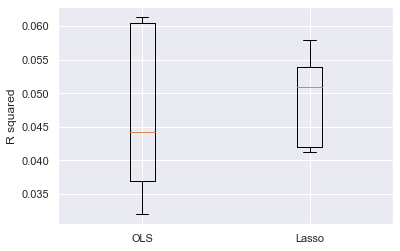

In [227]:
fig, ax = plt.subplots()
ax.boxplot([scores_full,scores_lasso])
plt.xticks([1, 2], ['OLS', 'Lasso'])
plt.ylabel('R squared')
#plt.title('Out-of-sample validation')
plt.savefig('results\plots\outofsample_validation_onJob.png', bbox_inches='tight')


NOTE: out-of-sample performance of regularized model (Lasso) appears to be better--> less noise in the data and thus no overfitting.

### 3.2. Open Education

In [228]:
nona = y_X.drop(columns = ["on_job","training","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]

In [229]:

y = nona["open_educ"]
X = nona.iloc[:, 1:]

#X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
#X = StandardScaler().fit_transform(X)

In [230]:
# Use K-fold out-of-sample validation to compare the predictive power of the full and of the reduced model
from sklearn.model_selection import KFold, cross_val_score

y = nona["open_educ"]
X = nona.iloc[:, 1:]

kf = KFold(n_splits=5, shuffle=True, random_state=1) # we use five splits, randam_state makes sure we can replacte the data (get same random numbers)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_full = cross_val_score(pipe, X, y, cv=kf)
print("scores full")
print(scores_full)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_full.mean(), scores_full.std() * 2))

scores full
[-0.00961504  0.00688624 -0.03395557 -0.04386874  0.0426989 ]
Accuracy: -0.00757 (+/- 0.06167)


In [231]:
# optimal lasso penalty
from sklearn.linear_model import LassoCV
import time
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-2.5, -0.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X, y)
t_cv = time.time() - t1
print("Ready")
l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0566 
Training time =  0.4083s 


In [232]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
scores_lasso = cross_val_score(pipe, X, y, cv=kf)
print(scores_lasso)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_lasso.mean(), scores_lasso.std() * 2))

[0.00750928 0.02147971 0.02019629 0.00677655 0.04264104]
Accuracy: 0.01972 (+/- 0.02601)


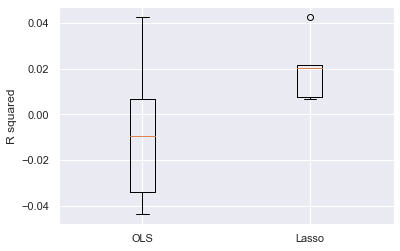

In [233]:
fig, ax = plt.subplots()
ax.boxplot([scores_full, scores_lasso])
plt.xticks([1, 2], ['OLS', 'Lasso'])
plt.ylabel('R squared')
#plt.title('Out-of-sample validation, open education')
plt.savefig('results\plots\outofsample_validation_openEduc.png', bbox_inches='tight')
#plt.savefig('plots\outofsample_validation_openEduc.png', bbox_inches='tight')


## 4. Lasso
### 4.1 Lasso - on the job training

In [319]:
# Use K-fold out-of-sample validation to select the 'best' $\lambda$. Plot average out-of-sample error as a function of $\lambda$. 
# Note: can take some time
from sklearn.linear_model import LassoCV
import time

nona = y_X.drop(columns = ["open_educ","training","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]

y = nona["on_job"]
X = nona.iloc[:, 1:]



#X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
#X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.05, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))


In-sample Rsq:  0.0613
Out-of-sample Rsq:  0.0500


Computing regularization path using the lasso...
Ready


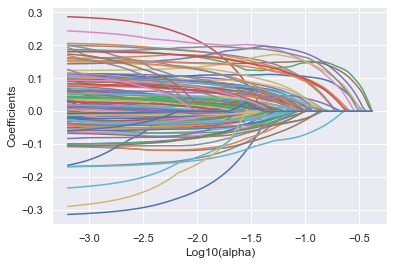

In [320]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)
#plt.grid(axis='both')
plt.xlabel('Log10(alpha)')
plt.ylabel('Coefficients')
#plt.title('Lasso Path')
plt.axis('tight')

#plt.savefig('plots\lasso_path_onJob.png', bbox_inches='tight')
plt.savefig('results\plots\lasso_path_onJob.png', bbox_inches='tight')
#plt.show()


Lasso Path shows the path of estimated coefficients for different values of $\lambda$. When $\lambda$ approaches zero, we are close to the OLS with all the variables. The path also shows us the $\lambda$ when all the coefficients are zero (null model). For this graph such $\lambda$ is around log(-1). It is helpful for the next step, when we define the search grid to find the optimal $\lambda$. 
#### 4.1.1 Selecting optimal $\lambda$ with cross-validation

In [321]:
from sklearn.linear_model import LassoCV
import time

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-3, -2.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .6f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.003162 
Training time =  2.4181s 


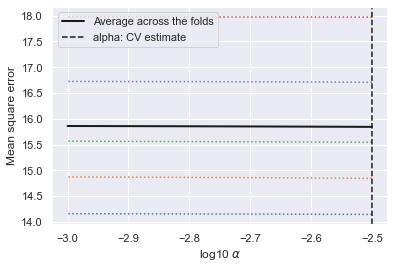

In [322]:
# Display results
log_alphas_lasso = np.log10(l.alphas_)

plt.figure()
plt.plot(log_alphas_lasso , l.mse_path_, ':')
plt.plot(log_alphas_lasso , l.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(l.alpha_) , linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'log10 $\alpha$')
plt.ylabel('Mean square error')
#plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.savefig('results\plots\lasso_MSE_fold_onJob.png', bbox_inches='tight')#plt.savefig('plots\lasso_MSE_fold_onJob.png', bbox_inches='tight')
#plt.savefig('plots\lasso_MSE_fold_onJob.png', bbox_inches='tight')#plt.savefig('plots\lasso_MSE_fold_onJob.png', bbox_inches='tight')

Constant MSE 

#### 4.1.2 Optimal alpha as calculated using the cross-validation

In [323]:

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])


pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.0755
Out-of-sample Rsq:  0.0467


In [324]:
# rerun the regression with optmal penalty 

lass = pipe.fit(X_train, y_train)
y_pred=lass.predict(X_test)


In [325]:
# we can also check which coefficients were selected by LASSO 
pipe.named_steps['lasso'].coef_ # note the syntaxis pipe.named_steps

array([-2.92753815e-01, -4.37829872e-03,  1.79486169e-01,  2.66616306e-01,
        1.10980035e-01,  1.50865128e-01,  5.27809917e-02, -1.59131563e-01,
        2.04590881e-02, -8.96565238e-03, -8.38294161e-04,  0.00000000e+00,
        6.30860378e-03, -7.24958844e-03,  1.79173783e-02,  1.36302275e-02,
        0.00000000e+00,  9.39957161e-03,  1.89397946e-02,  7.61008792e-02,
        1.03459447e-01, -4.83821608e-03, -3.69135467e-02, -1.73968603e-02,
        5.55922938e-02, -2.23127402e-02,  4.93511406e-02,  7.59525613e-02,
        4.91478591e-02, -6.65647887e-02,  1.04738671e-01,  1.95512559e-01,
       -6.43965317e-02,  8.81944746e-02, -2.08369046e-02,  9.43673273e-02,
       -5.59052240e-02,  1.91667238e-01,  1.41898228e-01,  9.90646509e-03,
        1.00389071e-01, -2.36787100e-02,  3.52553617e-03,  4.63799430e-02,
        5.33417179e-02, -1.16666206e-01, -7.27503374e-02, -5.39501172e-02,
        9.57328707e-02,  4.98600076e-02, -3.59590338e-02, -1.16525112e-01,
       -2.50712224e-02,  

In [326]:
imp = pd.DataFrame(pipe.named_steps['lasso'].coef_, columns = ['Lasso coefficient'])
imp['Feature'] = list(X_train.columns)
imp

,Lasso coefficient,Feature
0,-0.292754,age_r
1,-0.004378,j_q03b
2,0.179486,yrsget
3,0.266616,c_q09
4,0.110980,c_q10a
...,...,...
156,0.073940,d_q14_Neither satisfied nor dissatisfied
157,0.109439,d_q14_Satisfied
158,-0.245979,skill_1
159,-0.200437,skill_2


In [327]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp

,Lasso coefficient,Feature
0,-0.292754,age_r
1,-0.004378,j_q03b
2,0.179486,yrsget
3,0.266616,c_q09
4,0.110980,c_q10a
...,...,...
156,0.073940,d_q14_Neither satisfied nor dissatisfied
157,0.109439,d_q14_Satisfied
158,-0.245979,skill_1
159,-0.200437,skill_2


In [328]:
imp.to_excel('results\models\lin_lasso_coef.xlsx')

In [329]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp= imp[~imp['Feature'].astype(str).str.startswith('isic1c')]
imp= imp[~imp['Feature'].astype(str).str.startswith('cntryid')]
imp.reset_index(drop=True, inplace=True)
imp


,Lasso coefficient,Feature
0,-0.292754,age_r
1,-0.004378,j_q03b
2,0.179486,yrsget
3,0.266616,c_q09
4,0.110980,c_q10a
...,...,...
96,0.073940,d_q14_Neither satisfied nor dissatisfied
97,0.109439,d_q14_Satisfied
98,-0.245979,skill_1
99,-0.200437,skill_2


In [330]:
from tabulate import tabulate
headers = ["Coefficients", "Feature"]
print(tabulate(imp, headers, tablefmt="pipe"))

|     |   Coefficients | Feature                                                                               |
|----:|---------------:|:--------------------------------------------------------------------------------------|
|   0 |   -0.292754    | age_r                                                                                 |
|   1 |   -0.0043783   | j_q03b                                                                                |
|   2 |    0.179486    | yrsget                                                                                |
|   3 |    0.266616    | c_q09                                                                                 |
|   4 |    0.11098     | c_q10a                                                                                |
|   5 |    0.150865    | readytolearn                                                                          |
|   6 |    0.052781    | earnmthallppp                                                          

In [331]:
imp.sort_values("Lasso coefficient").head(30)

,Lasso coefficient,Feature
0,-0.292754,age_r
98,-0.245979,skill_1
99,-0.200437,skill_2
47,-0.162642,d_q13c_Less than once a month
7,-0.159132,g_q05e_Every day
36,-0.105282,edcat8_Tertiary – professional degree (ISCED 5B)
60,-0.098550,"b_q01b_Engineering, manufacturing and construc..."
57,-0.094800,b_q10c_Not useful at all
48,-0.094277,d_q13c_Less than once a week but at least once...
67,-0.079501,g_q06_Straightforward


In [332]:
imp.sort_values("Lasso coefficient", ascending = False).head(30)

,Lasso coefficient,Feature
3,0.266616,c_q09
62,0.186284,b_q01b_Health and welfare
2,0.179486,yrsget
94,0.177062,"d_q04_t_Employee, supervising more than 5 people"
56,0.166267,d_q03_The public sector (for example the local...
5,0.150865,readytolearn
92,0.150531,b_q26a_t_Yes
59,0.149894,b_q10c_Very useful
78,0.145367,g_q05g_Never
95,0.126982,d_q14_Extremely satisfied


In [333]:

lass = pipe.fit(X_train, y_train)
y_pred=lass.predict(X_test)

print('Training accuracy:', lass.score(X_train, y_train))
print('Test accuracy:', lass.score(X_test, y_test))


Training accuracy: 0.07545311561164358
Test accuracy: 0.04666749884418664


#### Results
When Lasso is applied as a regularization method, 148 coefficients remain while 12 are being excluded for the regression of on the job training on the various explanatory variables. High skill level jobs and medium skill level jobs reduce the number of trainings stronger than low skilled jobs.

### 4.2 Lasso for open education

In [334]:
# Use K-fold out-of-sample validation to select the 'best' $\lambda$. Plot average out-of-sample error as a function of $\lambda$. 
# Note: can take some time
from sklearn.linear_model import LassoCV
import time

nona = y_X.drop(columns = ["on_job","training","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["open_educ"]
X = nona.iloc[:, 1:]

In [335]:

#X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns)
#X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.05, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.0786
Out-of-sample Rsq:  0.0070


Computing regularization path using the lasso...
Ready


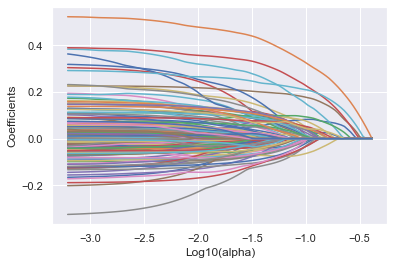

In [343]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('Coefficients')
#plt.title('Lasso Path')
plt.axis('tight')
#plt.grid(axis='both')
#plt.show()

#plt.savefig('plots\lasso_path_openeduc.png', bbox_inches='tight')
#plt.savefig('results\plots\lasso_path_openeduc.png', bbox_inches='tight')
plt.savefig('results\plots\lasso_path_openeduc.png', bbox_inches='tight', dpi=100)

#### 4.2.1 Selecting optimal $\lambda$ with cross-validation and information criteria

In [296]:
from sklearn.linear_model import LassoCV
import time

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-3, -2.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .6f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.003162 
Training time =  0.3533s 


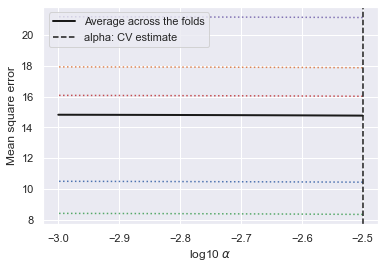

In [297]:
# Display results
log_alphas_lasso = np.log10(l.alphas_)

plt.figure()
plt.plot(log_alphas_lasso , l.mse_path_, ':')
plt.plot(log_alphas_lasso , l.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(l.alpha_) , linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'log10 $\alpha$')
plt.ylabel('Mean square error')
#plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.savefig('results\plots\lasso_MSE_fold_openeduc.png', bbox_inches='tight')
#plt.savefig('plots\lasso_MSE_fold_openeduc.png', bbox_inches='tight')

In [298]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])

pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.0987
Out-of-sample Rsq: -0.0071


In [299]:
# we can also check which coefficients were selected by LASSO 
pipe.named_steps['lasso'].coef_ # note the syntaxis pipe.named_steps

array([-0.15199878, -0.01387946,  0.025427  ,  0.28890955, -0.01360862,
        0.22463863, -0.06221559,  0.03640675,  0.21664653,  0.03203733,
        0.30076278,  0.03601776,  0.07915507,  0.04564192, -0.07986259,
       -0.03077484, -0.02337365, -0.11702502, -0.01866121, -0.        ,
        0.03565757,  0.00287966, -0.09711443, -0.00899534, -0.127509  ,
       -0.04718579, -0.09370402, -0.29824227,  0.0206675 , -0.02983733,
        0.04501333,  0.51094336,  0.15803336, -0.0296011 , -0.00967599,
        0.14239927,  0.01527186,  0.11962228,  0.15485752,  0.11575909,
        0.12289608,  0.0793579 , -0.04844892, -0.02398903,  0.08579802,
       -0.08410652, -0.05939981,  0.02000967, -0.03912417,  0.3672823 ,
       -0.00601177, -0.00700351, -0.00893867,  0.38136579, -0.02300281,
        0.03859628,  0.17742946,  0.02626564, -0.05241244, -0.01072155,
       -0.02944556,  0.01306296, -0.00097314, -0.00962121, -0.09943902,
        0.01145048,  0.04442196, -0.11353194, -0.08852209,  0.19

In [300]:
imp = pd.DataFrame(pipe.named_steps['lasso'].coef_, columns = ['Lasso coefficient'])
imp['Feature'] = list(X_train.columns)
imp

,Lasso coefficient,Feature
0,-0.151999,age_r
1,-0.013879,j_q03b
2,0.025427,yrsget
3,0.288910,c_q09
4,-0.013609,c_q10a
...,...,...
156,0.056941,d_q14_Neither satisfied nor dissatisfied
157,-0.000000,d_q14_Satisfied
158,0.122717,skill_1
159,-0.006556,skill_2


In [301]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp

,Lasso coefficient,Feature
0,-0.151999,age_r
1,-0.013879,j_q03b
2,0.025427,yrsget
3,0.288910,c_q09
4,-0.013609,c_q10a
...,...,...
155,0.033146,d_q14_Extremely satisfied
156,0.056941,d_q14_Neither satisfied nor dissatisfied
158,0.122717,skill_1
159,-0.006556,skill_2


In [302]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp= imp[~imp['Feature'].astype(str).str.startswith('isic1c')]
imp= imp[~imp['Feature'].astype(str).str.startswith('cntryid')]
imp.reset_index(drop=True, inplace=True)
imp

,Lasso coefficient,Feature
0,-0.151999,age_r
1,-0.013879,j_q03b
2,0.025427,yrsget
3,0.288910,c_q09
4,-0.013609,c_q10a
...,...,...
98,0.033146,d_q14_Extremely satisfied
99,0.056941,d_q14_Neither satisfied nor dissatisfied
100,0.122717,skill_1
101,-0.006556,skill_2


In [303]:
from tabulate import tabulate
headers = ["Coefficients", "Feature"]
print(tabulate(imp, headers, tablefmt="pipe"))

|     |   Coefficients | Feature                                                                               |
|----:|---------------:|:--------------------------------------------------------------------------------------|
|   0 |   -0.151999    | age_r                                                                                 |
|   1 |   -0.0138795   | j_q03b                                                                                |
|   2 |    0.025427    | yrsget                                                                                |
|   3 |    0.28891     | c_q09                                                                                 |
|   4 |   -0.0136086   | c_q10a                                                                                |
|   5 |    0.224639    | readytolearn                                                                          |
|   6 |   -0.0622156   | earnmthallppp                                                          

In [304]:
imp.sort_values("Lasso coefficient").head(30)

,Lasso coefficient,Feature
26,-0.298242,g_q05d_Never
60,-0.183465,b_q10c_Somewhat useful
53,-0.182790,g_q05h_Never
0,-0.151999,age_r
43,-0.146666,g_q05f_Never
55,-0.130121,pared_Neither parent has attained upper secondary
23,-0.127509,g_q05d_Every day
75,-0.118146,g_q08_Yes
17,-0.117025,g_q05a_Less than once a week but at least once...
37,-0.113532,edcat8_Tertiary – professional degree (ISCED 5B)


In [305]:
imp.sort_values("Lasso coefficient", ascending = False).head(30)

,Lasso coefficient,Feature
10,0.300763,g_q05e_Never
40,0.298119,g_q04_Yes
3,0.288910,c_q09
74,0.283448,d_q06a_More than 1000 people
5,0.224639,readytolearn
8,0.216647,g_q05e_Less than once a month
64,0.210205,b_q01b_Health and welfare
39,0.191632,"edcat8_Upper secondary (ISCED 3A-B, C long)"
66,0.160249,"b_q01b_Science, mathematics and computing"
84,0.151203,d_q09_No contract


In [253]:

lass = pipe.fit(X_train, y_train)
y_pred=lass.predict(X_test)

print('Training accuracy:', lass.score(X_train, y_train))
print('Test accuracy:', lass.score(X_test, y_test))

Training accuracy: 0.09866733536981664
Test accuracy: -0.007127834396619459


#### Results
When Lasso is applied as a regularization method, 150 coefficients remain while 10 are being excluded for the regression of open job training on the various explanatory variables. Working in a high skill level job increases the number of open trainings while working in a medium skill level job reduce the number of trainings. Working in a low level skill job increases the number of trainings slightly.

### 4.3 All training

In [254]:
y_X['training'] = y_X["open_educ"] + y_X["on_job"]
nona = y_X.drop(columns = ["on_job","open_educ", "isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["training"]
X = nona.iloc[:, 1:]
X = nona.drop(columns = ["training"])
X

,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,g_q05e_Every day,g_q05e_Less than once a month,g_q05e_Less than once a week but at least once a month,...,b_q26a_t_Yes,"d_q04_t_Employee, supervising fewer than 5 people","d_q04_t_Employee, supervising more than 5 people",d_q14_Extremely dissatisfied,d_q14_Extremely satisfied,d_q14_Neither satisfied nor dissatisfied,d_q14_Satisfied,skill_1,skill_2,skill_3
18504,38.0,1.0,12.0,15.0,1.0,1.751830,3065.1000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
18563,59.0,1.0,13.0,33.0,1.0,2.528040,2810.2000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
18721,56.0,2.0,14.0,34.0,1.0,2.570880,4362.7500,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
18946,44.0,3.0,11.0,21.0,2.0,3.018180,1049.0200,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
19005,56.0,2.0,13.0,33.0,1.0,3.818540,3176.4700,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225400,50.0,1.0,12.0,30.0,1.0,3.264357,4201.9243,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
225489,47.0,3.0,15.0,25.0,1.0,1.347538,5319.2324,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
225522,32.0,2.0,16.0,7.0,3.0,2.361803,3557.6936,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
225532,53.0,3.0,15.0,32.0,1.0,2.844822,3919.0398,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [255]:
# Use K-fold out-of-sample validation to select the 'best' $\lambda$. Plot average out-of-sample error as a function of $\lambda$. 
# Note: can take some time
from sklearn.linear_model import LassoCV
import time



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.05, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.1373
Out-of-sample Rsq:  0.0089


Computing regularization path using the lasso...
Ready


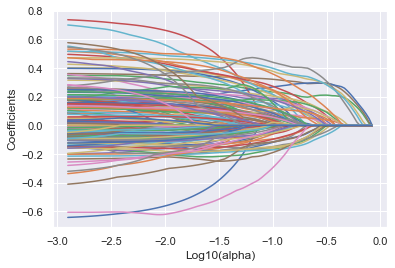

<Figure size 432x288 with 0 Axes>

In [256]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('Coefficients')
#plt.title('Lasso Path')
plt.axis('tight')
#plt.grid(axis='both')
plt.show()

plt.savefig('results\plots\lasso_path_training.png', bbox_inches='tight')
#plt.savefig('plots\lasso_path_alltraining.png', bbox_inches='tight')

In [257]:
plt.savefig('results\plots\lasso_path_training.png', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

#### Selecting optimal $\lambda$ with cross-validation and information criteria

In [258]:
from sklearn.linear_model import LassoCV
import time

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-3, -2.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0032 
Training time =  0.4389s 


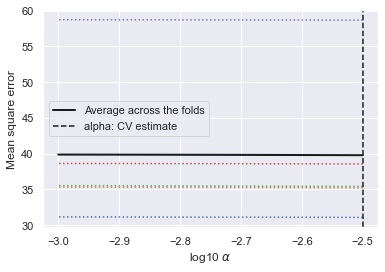

In [259]:
# Display results
log_alphas_lasso = np.log10(l.alphas_)

plt.figure()
plt.plot(log_alphas_lasso , l.mse_path_, ':')
plt.plot(log_alphas_lasso , l.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(l.alpha_) , linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'log10 $\alpha$')
plt.ylabel('Mean square error')
#plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.savefig('results\plots\lasso_MSE_fold_training.png', bbox_inches='tight')

#plt.savefig('plots\lasso_MSE_fold_alltraining.png', bbox_inches='tight')

In [260]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])

pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.1501
Out-of-sample Rsq: -0.0096


In [261]:
# we can also check which coefficients were selected by LASSO 
pipe.named_steps['lasso'].coef_ # note the syntaxis pipe.named_steps

array([-0.62267089,  0.12225315,  0.34630068,  0.71597809,  0.19689673,
        0.35752789,  0.11255474, -0.00274304,  0.39912951, -0.00333999,
        0.3951377 ,  0.15220067,  0.24102844,  0.1674788 , -0.19241341,
        0.12583726, -0.01518191, -0.02489278, -0.1010936 ,  0.20373191,
        0.18114857, -0.20074134, -0.06904201, -0.08012936, -0.0689626 ,
       -0.08935455,  0.08429912, -0.1330714 ,  0.1386239 , -0.06529638,
        0.12450097,  0.24164941,  0.15884737,  0.0152835 , -0.00179276,
        0.24523367, -0.04058359,  0.24302769,  0.41509283,  0.17660539,
       -0.11495161,  0.49824818, -0.16800096,  0.1590726 ,  0.40999472,
       -0.10867622, -0.01770969,  0.0649503 , -0.03324402,  0.66389387,
       -0.05141758,  0.06965412,  0.13639685,  0.47815316,  0.02427249,
        0.1476517 ,  0.31943971,  0.18548734,  0.3099201 , -0.08951585,
        0.01911917,  0.09854273,  0.06825689, -0.07726812, -0.17209138,
        0.01865417,  0.21916096, -0.17838978,  0.1216666 ,  0.48

In [262]:
imp = pd.DataFrame(pipe.named_steps['lasso'].coef_, columns = ['Lasso coefficient'])
imp['Feature'] = list(X_train.columns)
imp

,Lasso coefficient,Feature
0,-0.622671,age_r
1,0.122253,j_q03b
2,0.346301,yrsget
3,0.715978,c_q09
4,0.196897,c_q10a
...,...,...
156,0.253444,d_q14_Neither satisfied nor dissatisfied
157,0.506063,d_q14_Satisfied
158,-0.013104,skill_1
159,-0.067517,skill_2


In [263]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp

,Lasso coefficient,Feature
0,-0.622671,age_r
1,0.122253,j_q03b
2,0.346301,yrsget
3,0.715978,c_q09
4,0.196897,c_q10a
...,...,...
156,0.253444,d_q14_Neither satisfied nor dissatisfied
157,0.506063,d_q14_Satisfied
158,-0.013104,skill_1
159,-0.067517,skill_2


In [264]:
lass = pipe.fit(X_train, y_train)
y_pred=lass.predict(X_test)

print('Training accuracy:', lass.score(X_train, y_train))
print('Test accuracy:', lass.score(X_test, y_test))

Training accuracy: 0.1501428599371647
Test accuracy: -0.009554292326360514


#### Results
When Lasso is applied as a regularization method, 157 coefficients remain while 3 are being excluded for the regression of training in general on the various explanatory variables. Working in a high skill level job reduces the number of open trainings slightly. The effect is stronger for individuals working in a medium skill level job. Working in a low level skill job increases the number of trainings slightly.

## 5. Random Forest 

### 5.1 Open Education

In [428]:
nona = y_X.drop(columns = ["on_job","training"])
nona = nona.dropna()
y = nona["open_educ"]
X = nona.iloc[:, 1:]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 



In [429]:

rf = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: -0.027
Out-of-sample MSE: 16.462


In [430]:
# we can check whether we had enough trees in the forest
# Use cross-validation to determine the optimal number of trees
from sklearn.model_selection import cross_validate
import scipy as sp

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 1, \
        random_state = 1)
    cv_result = cross_validate(rf, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

<AxesSubplot:xlabel='Number of trees'>

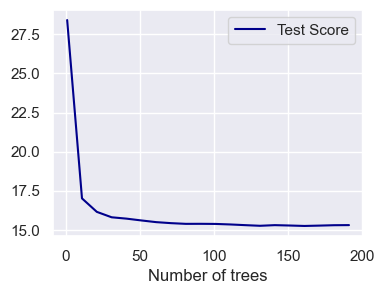

In [330]:


result = {}
for i in range(1, 200, 10):
    result[i] = cv_iter(i, 5, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# as we can see on the graph below, the MSE stabilizes with about 50 trees. 

In [331]:
#plt.savefig('results\plots\RF_numberTrees_openeduc.png', bbox_inches='tight')

plt.savefig('plots\RF_numberTrees_openeduc.png', bbox_inches='tight')


<Figure size 400x300 with 0 Axes>

In [334]:
# feature importance

imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
imp['Feature'] = list(X_train.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)


,Feature importance,Feature
0,0.066581,earnmthallppp
1,0.054255,readytolearn
2,0.047842,age_r
3,0.046822,c_q09
4,0.021299,yrsget
...,...,...
182,0.000000,cntryid_84093.0
183,0.000000,cntryid_Austria
184,0.000000,cntryid_Canada
185,0.000000,cntryid_Estonia


In [ ]:
imp.to_excel("RF_features_openEduc.xlsx")

#### Results
The most important features are the monthly salary and the willingness to learn. Also, the age of the participant and the years of work, the years of education needed to get the job, for how many different firms the individual already worked are also very important. Additionally, the dummy for the field of education in science, mathematics and computing are very important for the number of open educational trainings per year. 



#### For comparison - fitting a single decision tree

In [335]:
# put here the parameters for max_depth and min_samples_leaf that you determined in the previous step

cart = tree.DecisionTreeRegressor()
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Tree depth: 47
Out-of-sample Rsq: -1.209
Out-of-sample MSE: 35.400


In [336]:
from sklearn.model_selection import cross_validate
import scipy as sp

# write a function that runs a CV procedure for a candidate model of a given depth or with a given number of nodes
def cv_iter(max_depth, max_leaf_nodes, min_leafs, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1) # settings for CV
    cart = tree.DecisionTreeRegressor(max_depth = max_depth, max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_leafs, random_state = 1) # settings for CART
    cv_result = cross_validate(cart, X, y, scoring = 'neg_mean_squared_error') # output for CV, scoring = what is returned
    avg_score = np.mean(cv_result['test_score']) #average resutl for our N-folds
    return float(-avg_score)

1

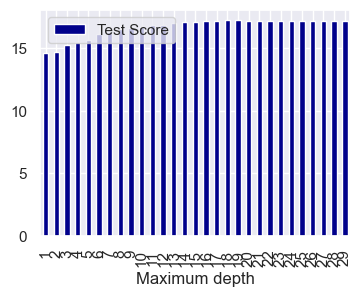

In [337]:
# Result when we iterate over candidate models of different depth
# Note: you can also try to iterate over models with a different number of nodes (see the lecture slides). 
result = {}
for i in range(1, 30):
    result[i] = cv_iter(i, None, 10, 5, X_train, y_train) #max_depth, max_leaf_nodes, min_samples_leaf, folds, X, y

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot.bar(color = 'DarkBlue', xlabel = 'Maximum depth')

results['Test Score'].idxmin()

Tree depth: 1
Out-of-sample Rsq: -0.007
Out-of-sample MSE: 16.133


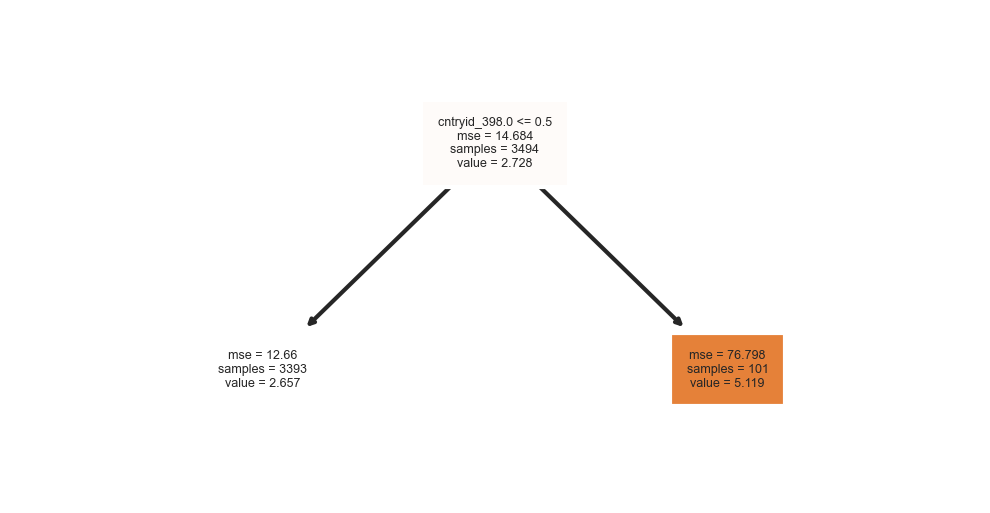

In [338]:
cart = tree.DecisionTreeRegressor( min_samples_leaf = 26, max_depth = results['Test Score'].idxmin(), random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

####  Pruning with Minimal Cost-Complexity

This pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. 
The goal is the find an optimal value of α which gives the maximum validation/test set accuracy.

- Parameter ccp_alpha provides a threshold for effective alphas, i.e. the process of pruning continues until the minimal effective alpha of the pruned tree is not greater than ccp_alpha. 

- The DecisionTreeClassifier class also provides a method cost_complexity_pruning_path which implements the pruning process and returns the effective alphas(and the corresponding impurities of there pruned trees)

In [339]:
# Complexity path 
# Note: here we don't need to set additional stopping rules. 
# The algorithm determines the optimal alpha, which fixes the number of terminal nodes.  

cart = tree.DecisionTreeRegressor(random_state = 1)

path = cart.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

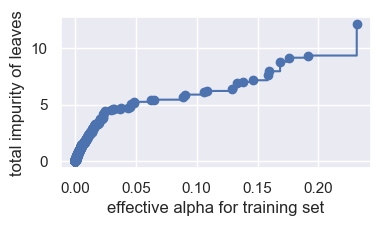

In [340]:
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 100})
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha for training set")
ax.set_ylabel("total impurity of leaves")
#ax.set_title("Total Impurity vs effective alpha for training set - open education")
plt.savefig('plots\costcomplexPruning_openeduc.png', bbox_inches='tight')
# Based on this graph, where would you expect the optimal alpha to be? 

As it is evident from the above plot, a value of alpha close to 0 corresponds to minimum impurity(unpruned tree) and as the value of alpha becomes larger the tree tends to be more impure.

In [341]:
# we define a function for cross-validation
def cv_iter(alpha, folds, X, y):
    cart = tree.DecisionTreeRegressor(ccp_alpha = alpha)
    cv_result = cross_validate(cart, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

6.000000000000001e-05

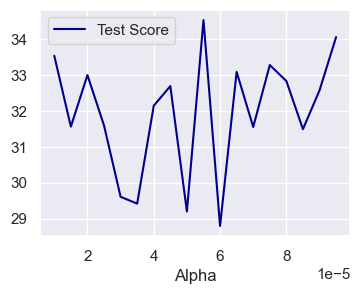

In [342]:
# attention: this CV takes some time, as we are fitting many forests, would suggest doing this in the very end... 
result = {}
for i in np.arange(0.00001, 0.0001, 0.000005): # you can also try a different grid for search 
    result[i] = cv_iter(i, 3, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Alpha')

results['Test Score'].idxmin()

Tree depth: 47
Out-of-sample Rsq: -0.992
Out-of-sample MSE: 31.919


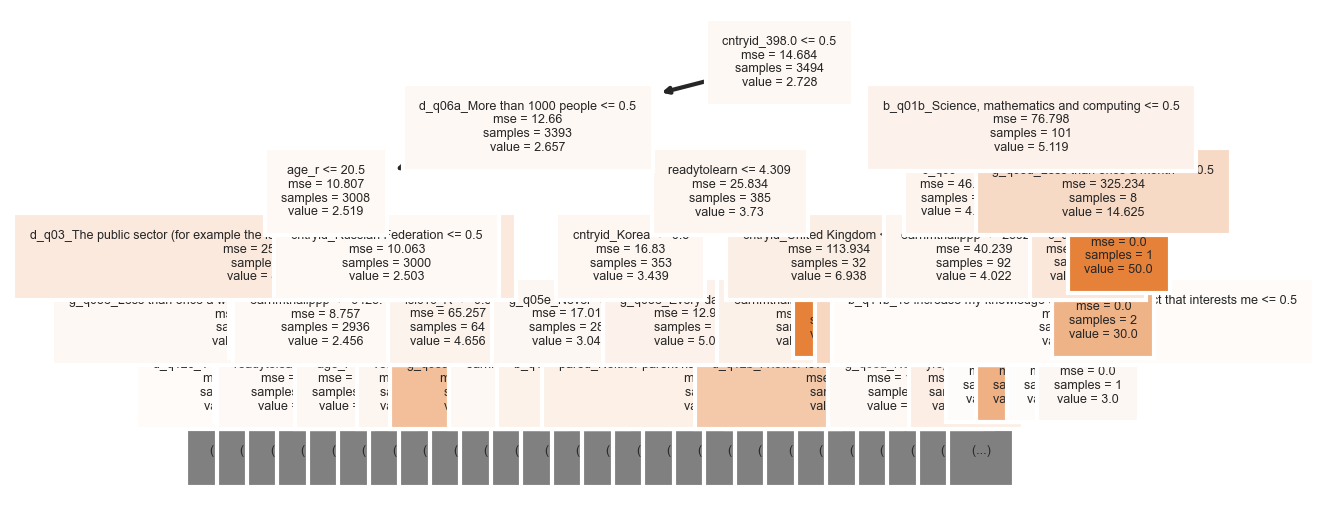

In [343]:
cart = tree.DecisionTreeRegressor( ccp_alpha = results['Test Score'].idxmin(), random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

### 5.2 On the job training

In [365]:
nona = y_X.drop(columns = ["open_educ", "training"])
nona = nona.dropna()
y = nona["on_job"]
X = nona.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 

#### Random forest 
with extra randomization (for each individual tree, we randomly select a subsample of covariates from X to split on)

In [345]:

rf = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: 0.008
Out-of-sample MSE: 14.969


Another random forest - without extra randomization

- this random forest without extra randomization yields a higher out-of-sample $R^2$

In [346]:


rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 1, min_samples_split = 2, oob_score = True, \
        random_state = 1)
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: 0.001
Out-of-sample MSE: 15.075


To check whether we had enough trees in the forest we use cross-validation to determine the optimal number of trees

In [347]:

from sklearn.model_selection import cross_validate
import scipy as sp

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 1, \
        random_state = 1)
    cv_result = cross_validate(rf, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

<AxesSubplot:xlabel='Number of trees'>

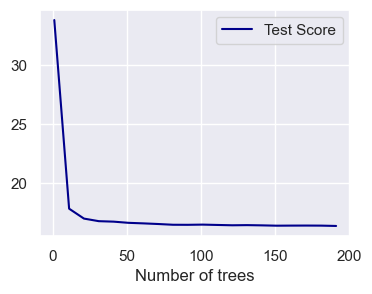

In [348]:
result = {}
for i in range(1, 200, 10):
    result[i] = cv_iter(i, 5, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# as we can see on the graph below, the MSE stabilizes with about 25 trees. 

In [349]:
#plt.savefig('results\plots\RF_numberTrees_openeduc.png', bbox_inches='tight')

plt.savefig('plots\RF_numberTrees_onJob.png', bbox_inches='tight')


<Figure size 400x300 with 0 Axes>

In [350]:
# feature importance

imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
imp['Feature'] = list(X_train.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)


,Feature importance,Feature
0,0.078354,earnmthallppp
1,0.065274,readytolearn
2,0.048514,age_r
3,0.039921,c_q09
4,0.031061,c_q10a
...,...,...
182,0.000000,c_q02a_Yes
183,0.000000,cntryid_Sweden
184,0.000000,cntryid_792.0
185,0.000000,cntryid_United States


#### Results
The most important features are the monthly salary and the willingness to learn. Also, the age of the participant and the years of work, the years of education needed to get the job, for how many different firms the individual already worked are also very important for the number of on the job trainings per year. 


#### For comparison - fitting a single decision tree

In [351]:
# put here the parameters for max_depth and min_samples_leaf that you determined in the previous step

cart = tree.DecisionTreeRegressor()
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Tree depth: 46
Out-of-sample Rsq: -1.126
Out-of-sample MSE: 32.087


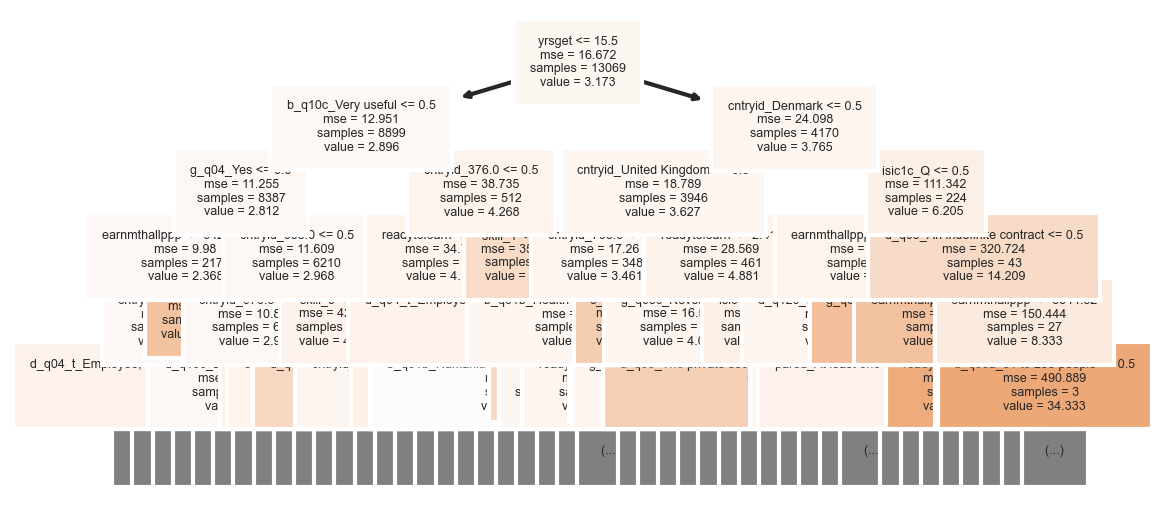

In [352]:
#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

###  Pruning with Minimal Cost-Complexity

This pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. 
The goal is the find an optimal value of α which gives the maximum validation/test set accuracy.

- Parameter ccp_alpha provides a threshold for effective alphas, i.e. the process of pruning continues until the minimal effective alpha of the pruned tree is not greater than ccp_alpha. 

- The DecisionTreeClassifier class also provides a method cost_complexity_pruning_path which implements the pruning process and returns the effective alphas(and the corresponding impurities of there pruned trees)

In [353]:
# Complexity path 
cart = tree.DecisionTreeRegressor(random_state = 1)

path = cart.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

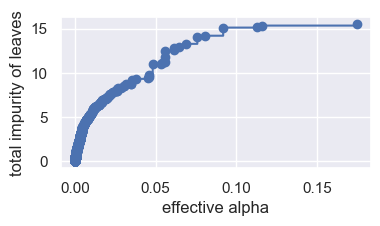

In [354]:
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 100})
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
#ax.set_title("Total Impurity vs effective alpha for training set - open education")
plt.savefig('plots\costcomplexPruning_onjob.png', bbox_inches='tight')
# Based on this graph, where would you expect the optimal alpha to be? 

As it is evident from the above plot, a value of alpha close to 0 corresponds to minimum impurity(unpruned tree) and as the value of alpha becomes larger the tree tends to be more impure.

In [355]:
# we define a function for cross-validation
def cv_iter(alpha, folds, X, y):
    cart = tree.DecisionTreeRegressor(ccp_alpha = alpha)
    cv_result = cross_validate(cart, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

5.500000000000001e-05

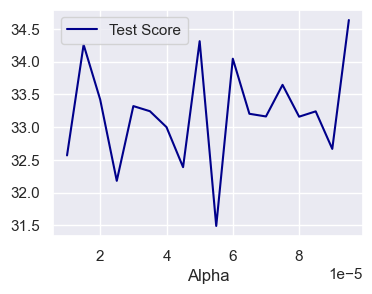

In [356]:
# attention: this CV takes some time, as we are fitting many forests, would suggest doing this in the very end... 
result = {}
for i in np.arange(0.00001, 0.0001, 0.000005): # you can also try a different grid for search 
    result[i] = cv_iter(i, 3, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Alpha')

results['Test Score'].idxmin()

Tree depth: 45
Out-of-sample Rsq: -0.965
Out-of-sample MSE: 29.660


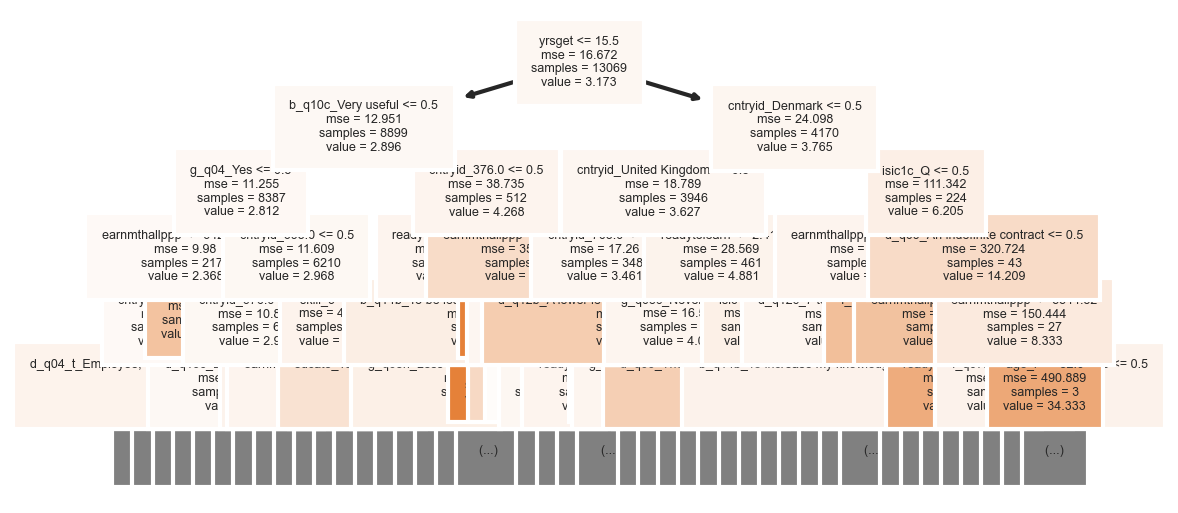

In [357]:
# put here the parameter for ccp_alpha that you determined in the previous step 

cart = tree.DecisionTreeRegressor( ccp_alpha = results['Test Score'].idxmin(), random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);